## prerequisites

In [1]:
# !pip install transformers

import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFGPT2LMHeadModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tqdm

In [2]:
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', pad_token='<pad>')
model = TFGPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2', from_pt=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.0.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'lm_head.weight', 'transformer.h.1.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2LMHeadModel from a PyTorch model that you expe

In [3]:
for _ in range(15):
    print(f'# {_} :', tokenizer.decode(_))

# 0 : <s>
# 1 : </s>
# 2 : <usr>
# 3 : <pad>
# 4 : <sys>
# 5 : <unk>
# 6 : <mask>
# 7 : <d>
# 8 : </d>
# 9 : <unused0>
# 10 : <unused1>
# 11 : <unused2>
# 12 : <unused3>
# 13 : <unused4>
# 14 : <unused5>


## 데이터 전처리

In [53]:
df = pd.read_csv('all_wellness_1.csv')
df.rename(columns = {'user' : 'question', 'system' : 'response',
                    'sentiment' : 'label'}, inplace = True)

In [54]:
print(df.shape)
print('-' * 20)
print('If any NaN Values : ', df.isnull().values.any())
print('-' * 20)
df.head()

(333917, 3)
--------------------
If any NaN Values :  False
--------------------


,question,response,label
0,12시 땡!,하루가 또 가네요.,일상
1,1지망 학교 떨어졌어,위로해 드립니다.,일상
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,일상
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,일상
4,PPL 심하네,눈살이 찌푸려지죠.,일상


In [55]:
df = df.sample(frac=1).reset_index(drop=True)
print(df.shape)
df.head()

(333917, 3)


,question,response,label
0,동정심이 앞서니까 일도 잘 안 되는 느낌이야.,가만히 앉아있을 수 없을 정도로 안절부절 못하시나요?,초조함
1,나처럼 나쁜 사람 본 적이 없어,당신이 주변 사람들을 실망시킨다고 느끼시나요?,죄책감
2,엄마가 염치 없다고 욕이라도 했으면 좋겠어,00님의 잘못이 아니에요. 혹시라도 자책하는 것이 버릇이 되실까 걱정이 들어요.,죄책감
3,외출하기 싫어요.,하루 종일 집에서 TV만 보며 누워있게 되나요?,무기력
4,멍 때림.,마음이 우울해서 힘드셨군요. 00님의 소식이 궁금했는데 마침 저를 잘 찾아주셨네요.,우울감


In [56]:
cnt = df.label.value_counts()
cnt = pd.DataFrame({'val' : cnt.index, 'label' : cnt.values})
print(f'# of individual sentiments : ', len(np.unique(df.label)))
print('-' * 20)
cnt.head()

# of individual sentiments :  361
--------------------


,val,label
0,초조함,42707
1,불면,37059
2,무기력,33039
3,슬픔,28004
4,자존감저하,24373


10 individual labels cover up 74.17% of the dataset
50 individual labels cover up 97.34% of the dataset
100 individual labels cover up 98.27% of the dataset


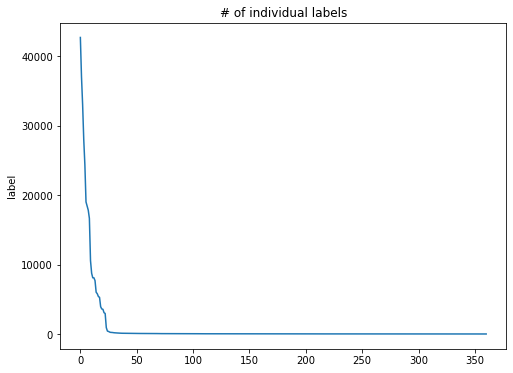

mean : 924.98
median : 27.00


In [57]:
print('{} individual labels cover up {:.2f}% of the dataset'.format(10, np.sum(cnt.label[:10])/len(df)*100))
print('{} individual labels cover up {:.2f}% of the dataset'.format(50, np.sum(cnt.label[:50])/len(df)*100))
print('{} individual labels cover up {:.2f}% of the dataset'.format(100, np.sum(cnt.label[:100])/len(df)*100))

plt.figure(figsize = (8, 6))
sns.lineplot(data = cnt, x = cnt.index, y = cnt.label)
plt.title('# of individual labels')
plt.show()

print('mean : {:.2f}'.format(np.mean(cnt.label)))
print('median : {:.2f}'.format(np.median(cnt.label)))

In [58]:
rsp = pd.DataFrame({'index' : df.response.value_counts().keys(),
                   'values' : df.response.value_counts().values})

print(f'# of individual responses : {len(rsp)} responses ')

rsp.head()

# of individual responses : 9112 responses 


,index,values
0,가만히 앉아있을 수 없을 정도로 안절부절 못하시나요?,3049
1,하루에 30분도 차분히 앉아있지 못하고 뭔가를 해야 한다는 조바심이 느껴지시나요?,3049
2,요즘 항상 짜증을 내시나요?,3049
3,늘 쫓기는 느낌으로 불편하신가요?,3049
4,마음이 예민하면 체력도 빨리 소모되는 기분이 드는 거 같아요. 많이 힘들어 보여 걱...,3049


10 individual responses cover up 10.04% of the dataset
100 individual responses cover up 59.52% of the dataset
1000 individual responses cover up 95.95% of the dataset


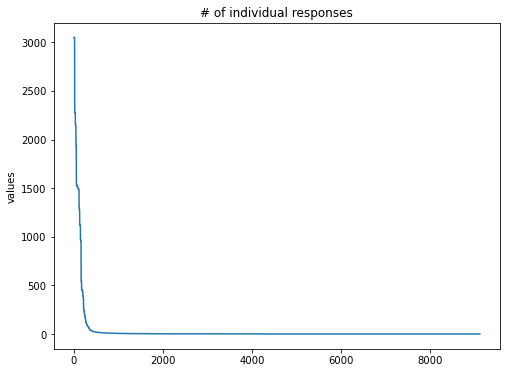

mean : 36.65
median : 1.00


In [59]:
print('{} individual responses cover up {:.2f}% of the dataset'.format(10, np.sum(rsp.loc[:10, 'values'])/len(df)*100))
print('{} individual responses cover up {:.2f}% of the dataset'.format(100, np.sum(rsp.loc[:100, 'values'])/len(df)*100))
print('{} individual responses cover up {:.2f}% of the dataset'.format(1000, np.sum(rsp.loc[:1000, 'values'])/len(df)*100))

plt.figure(figsize = (8, 6))
sns.lineplot(data = rsp, x = rsp.index, y = 'values')
plt.title('# of individual responses')
plt.show()

print('mean : {:.2f}'.format(np.mean(rsp['values'])))
print('median : {:.2f}'.format(np.median(rsp['values'])))

### Normalize responses

In [60]:
zeros = np.zeros((len(df), 2))
cnt_df = pd.DataFrame(zeros, columns = ['cnt_response', 'cnt_label'])

dict_response = {}
dict_label = {}

for _ in tqdm.notebook.tqdm(range(len(df))):
    try:
        cnt_df.loc[_, 'cnt_response'] += dict_response[df.loc[_, 'response']]
    except:
        dict_response[df.loc[_, 'response']] = 1
        cnt_df.loc[_, 'cnt_response'] += dict_response[df.loc[_, 'response']]
        
    dict_response[df.loc[_, 'response']] += 1
    
for _ in tqdm.notebook.tqdm(range(len(df))):
    try:
        cnt_df.loc[_, 'cnt_label'] += dict_label[df.loc[_, 'label']]
    except:
        dict_label[df.loc[_, 'label']] = 1
        cnt_df.loc[_, 'cnt_label'] += dict_label[df.loc[_, 'label']]
        
    dict_label[df.loc[_, 'label']] += 1

  0%|          | 0/333917 [00:00<?, ?it/s]

  0%|          | 0/333917 [00:00<?, ?it/s]

In [61]:
df = pd.concat([df, cnt_df], axis = 1)

In [64]:
df.loc[50:55, :]

,question,response,label,cnt_response,cnt_label
50,계속 잠만 자다 보니까 제가 너무 한심하게 느껴지긴 해요.,피로하면 몸뿐만 아니라 마음도 괴로워지는 거 같아요.,피로,1.0,4.0
51,가족끼리 다 아는 동네 아저씨였어요.,"네, 듣고 있어요. 더 이야기해주세요.",어린시절,1.0,1.0
52,걱정돼서 미치겠어,불안과 긴장이 많아져 힘드셨겠어요. 불안 증상이 계속되면 병원에 가서 도움을 받는 ...,긍정답변,1.0,2.0
53,속상한 기분이 들어.,슬프고 불행해서 도저히 견딜 수 없나요?,슬픔,2.0,3.0
54,또 실수할까봐 가슴이 울렁대요,아무 이유 없이 편안하게 쉴 수가 없나요?,불안,1.0,3.0
55,늘어지기만 하는 것 같아,잠을 자다 자주 깨나요?,불면,1.0,4.0


shape of df :  (24308, 5)
--------------------
10 individual responses cover up 1.67% of the dataset
100 individual responses cover up 15.37% of the dataset
1000 individual responses cover up 82.03% of the dataset


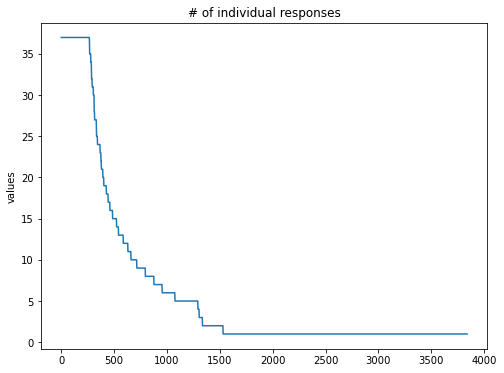

mean : 6.33
median : 1.00


In [65]:
df_mean = df[(df['cnt_label'] <= 925) & (df['cnt_response'] <= 37)]
print(f'shape of df : ', df_mean.shape)
print('-' * 20)

rsp = pd.DataFrame({'index' : df_mean.response.value_counts().keys(),
                   'values' : df_mean.response.value_counts().values})

print('{} individual responses cover up {:.2f}% of the dataset'.format(10, np.sum(rsp.loc[:10, 'values'])/len(df_mean)*100))
print('{} individual responses cover up {:.2f}% of the dataset'.format(100, np.sum(rsp.loc[:100, 'values'])/len(df_mean)*100))
print('{} individual responses cover up {:.2f}% of the dataset'.format(1000, np.sum(rsp.loc[:1000, 'values'])/len(df_mean)*100))

plt.figure(figsize = (8, 6))
sns.lineplot(data = rsp, x = rsp.index, y = 'values')
plt.title('# of individual responses')
plt.show()

print('mean : {:.2f}'.format(np.mean(rsp['values'])))
print('median : {:.2f}'.format(np.median(rsp['values'])))

10 individual labels cover up 31.89% of the dataset
50 individual labels cover up 63.74% of the dataset
100 individual labels cover up 76.30% of the dataset


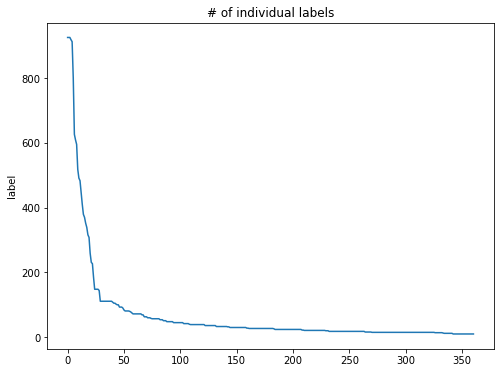

mean : 67.34
median : 27.00


In [66]:
cnt = df_mean.label.value_counts()
cnt = pd.DataFrame({'val' : cnt.index, 'label' : cnt.values})

print('{} individual labels cover up {:.2f}% of the dataset'.format(10, np.sum(cnt.label[:10])/len(df_mean)*100))
print('{} individual labels cover up {:.2f}% of the dataset'.format(50, np.sum(cnt.label[:50])/len(df_mean)*100))
print('{} individual labels cover up {:.2f}% of the dataset'.format(100, np.sum(cnt.label[:100])/len(df_mean)*100))

plt.figure(figsize = (8, 6))
sns.lineplot(data = cnt, x = cnt.index, y = cnt.label)
plt.title('# of individual labels')
plt.show()

print('mean : {:.2f}'.format(np.mean(cnt.label)))
print('median : {:.2f}'.format(np.median(cnt.label)))

In [22]:
del df; del rsp; del cnt;
del cnt_df; del dict_response; del dict_label

In [23]:
df_mean.to_csv('all_wellness.csv', index = False)

## Tokenize Data

In [24]:
df = pd.read_csv('all_wellness.csv')
df.head()

,question,response,label,cnt_response,cnt_label
0,남편이 바람을 피울것 같아서 너무 힘들어,다른 사람보다 못하다고 느끼시나요?,자존감저하,1.0,1.0
1,계속 불쾌한 기분이 들어서 아무 것도 못 하겠어,평소와 비교하여 수면 시간이 줄어드셨나요?,불면,1.0,1.0
2,이러니까 방법이 없어서 그냥 계속 우울하기만 해요.,머릿속이 늘 뿌연 것 같나요?,우울감,1.0,1.0
3,원래 진짜 가만히 못 있는 성격인데 누워만 있는 내가 놀라워,평소 즐기던 일이 더 이상 즐겁지 않거나 흥미가 사라졌나요?,무기력,1.0,1.0
4,망설여요,간단한 일이라도 여러가지 일이 있을 때 우선 순위를 정할 수 없으신가요?,자신감저하,1.0,1.0


In [25]:
batch_size = 32

In [26]:
def tokenize_df():
    for question, label, response in zip(df.question.to_list(),
                                         df.label.to_list(), df.response.to_list()):
        bos_token = [tokenizer.bos_token_id]
        eos_token = [tokenizer.eos_token_id]
        
        sentence = tokenizer.encode('<unused0>' + question + '<unused1>' + label + '<unused2>' + response)
        
        yield bos_token + sentence + eos_token

In [27]:
dataset = tf.data.Dataset.from_generator(tokenize_df, output_types = tf.int32)

dataset = dataset.padded_batch(batch_size = batch_size, padded_shapes=(None,),
                               padding_values = tokenizer.pad_token_id)

for batch in dataset:
    print(batch)
    break

tf.Tensor(
[[    1     9 25533 ...     3     3     3]
 [    1     9  9716 ...     3     3     3]
 [    1     9  9420 ...     3     3     3]
 ...
 [    1     9 26643 ...     3     3     3]
 [    1     9 10223 ...     3     3     3]
 [    1     9 19841 ...     3     3     3]], shape=(32, 44), dtype=int32)


In [28]:
print(batch[0])
print('-' * 20)
print(tokenizer.decode(batch[0]))

tf.Tensor(
[    1     9 25533 29329  9301  8095  6860 50534 12371 45231    10 37819
  6830  8185  8702    11  9306  9179  9518  9350 12524 12818 33810  8084
   406     1     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3], shape=(44,), dtype=int32)
--------------------
</s><unused0> 남편이 바람을 피울것 같아서 너무 힘들어<unused1> 자존감저하<unused2> 다른 사람보다 못하다고 느끼시나요?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


## Train Model

In [29]:
## Hyperparameters

EPOCHS = 20
adam = tf.keras.optimizers.Adam(learning_rate = 3e-5, epsilon=1e-08)
steps = len(df) // batch_size + 1

In [ ]:
for epoch in range(EPOCHS):
    epoch_loss = 0

    try:
        for batch in tqdm.notebook.tqdm(dataset, total=steps):
            try:
                with tf.GradientTape() as tape:
                    result = model(batch, labels = batch)
                    loss = result[0]
                    batch_loss = tf.reduce_mean(loss, -1)
      
                grads = tape.gradient(batch_loss, model.trainable_variables)
                adam.apply_gradients(zip(grads, model.trainable_variables))
                epoch_loss += batch_loss / steps
                
            except:
                pass
            
    except:
        pass

In [23]:
# save fine-tuned tokenizer & model

tokenizer.save_pretrained('chatbot')
model.save_pretrained('chatbot')

('chatbot/tokenizer_config.json',
 'chatbot/special_tokens_map.json',
 'chatbot/vocab.json',
 'chatbot/merges.txt',
 'chatbot/added_tokens.json',
 'chatbot/tokenizer.json')

## Load Data

In [2]:
# load fine-tuned model

tokenizer = AutoTokenizer.from_pretrained('chatbot', bos_token='</s>', eos_token='</s>', pad_token='<pad>')
model = TFGPT2LMHeadModel.from_pretrained('chatbot')

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at chatbot.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [46]:
def chatbot(text):
    sentence = '<unused0>' + text + '<unused1>'
    tokenized = [tokenizer.bos_token_id] + tokenizer.encode(sentence)
    tokenized = tf.convert_to_tensor([tokenized])
    
    result = model.generate(tokenized, min_length = 50, max_length = 200, repetition_penalty = 0.8,
                            do_sample = True, no_repeat_ngram_size = 3, temperature = 0.01,
                            top_k = 5)
    
    output = tokenizer.decode(result[0].numpy().tolist())
    response = output.split('<unused1> ')[1]
    label = response.split('<unused2> ')[0]
    response = response.split('<unused2> ')[1].replace('</s>', '')
    
    return label, response

In [47]:
label, ans = chatbot('친구가 내 마음을 몰라주는 것 같아 걱정이야')

print('예상 태그 :', label)
print('답변 :', ans)

질문 태그 : 자존감저하
답변 : 사람들이 나에게 차갑게 대하는 것 같으신가요?


In [48]:
label, ans = chatbot('노력해도 안되더라')

print('예상 태그 :', label)
print('답변 :', ans)

예상 태그 : 집중력저하
답변 : 생각하거나 집중하는 것이 어려우신가요?


In [50]:
label, ans = chatbot('먹어도 먹어도 아주 배고파요')

print('예상 태그 :', label)
print('답변 :', ans)

예상 태그 : 식욕저하
답변 : 입맛이 없으시다니 00님이 걱정돼요. 식사를 잘 하셔야 건강하게 몸을 관리하실 수 있는데 말이에요.


In [51]:
label, ans = chatbot('수강신청을 망쳐서 휴학을 하고 싶어요.')

print('예상 태그 :', label)
print('답변 :', ans)

예상 태그 : 무기력
답변 : 이전에 비해 매사에 의욕이 없나요?


In [52]:
label, ans = chatbot('여자친구가 없어서 슬퍼요')

print('예상 태그 :', label)
print('답변 :', ans)

예상 태그 : 사랑
답변 : 슬프고 불행해서 도저히 견딜 수 없나요?


In [ ]:
label, ans = chatbot('여자친구가 없어서 슬퍼요')

print('예상 태그 :', label)
print('답변 :', ans)

In [ ]:
# https://ratsgo.github.io/nlpbook/docs/generation/inference1/